In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras import backend as K
import os
import numpy as np
import uuid
import re

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
import timeit

In [4]:
from trainlib.ModelCollection import ModelCollection
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.FileCollection import FileCollection
import trainlib.cuts as cuts
from trainlib.utils import read_data

Welcome to JupyROOT 6.10/09


In [5]:
confhandler = ModelCollectionConfigFileHandler()

In [6]:
run_dir = "/data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/"

In [7]:
confhandler.load_configuration(os.path.join(run_dir, "settings.conf"))

attempting to load configuration file from /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/settings.conf


In [8]:
mcolls = confhandler.GetModelCollection(weightpath = os.path.join(run_dir, "training/"))

got the following list of hyperparams: {u'number_layers': 2.0, u'number_neurons': 64.0}
building network with 28 inputs
FlexiblePCAPreprocessor set up for 28 inputs
got the following list of hyperparams: {u'number_layers': 2.0, u'number_neurons': 64.0}
building network with 10 inputs
FlexiblePCAPreprocessor set up for 10 inputs
got the following list of hyperparams: {u'number_layers': 2.0, u'number_neurons': 64.0}
building network with 15 inputs
FlexiblePCAPreprocessor set up for 15 inputs
found the following models belonging to this collection:
D_VBF_ggH_2j_ML
D_VBF_ggH_0j_ML
D_VBF_ggH_1j_ML
now attempting to load model from file /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/training/D_VBF_ggH_ML/D_VBF_ggH_2j_ML/final.hdf5
read weights from /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/training/D_VBF_ggH_ML/D_VBF_ggH_2j_ML/final.hdf5
now attempting to load column settings from file /data_CMS/cms/wind/180508_bkg_cat_ZXon

2018-05-09 18:01:22.818665: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-09 18:01:22.818705: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-09 18:01:22.818713: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.


In [9]:
network_name = "D_VBF_WHh_ML"

In [26]:
fixed_input = {"nCleanedJetsPt30": 2}

In [11]:
# find the desired neural network, as given by its name; and hold on to the network itself and its preprocessor

In [10]:
for mcoll in mcolls:
    if network_name in mcoll.model_dict.keys():
        found_mcoll = mcoll
        model = mcoll.model_dict[network_name]
        pre = mcoll.preprocessor_dict[network_name]
        break

In [11]:
# the actual names of the dataframe columns
column_names = list(set(map(lambda x: re.sub('\[.*\]', '', x), pre.periodic_columns + pre.nonperiodic_columns)))

In [12]:
column_names

[u'D_VBF1j_ggH_ME',
 u'ZZPt',
 u'ZZPhi',
 u'PFMET',
 u'ZZEta',
 u'JetPt',
 u'JetPhi',
 u'D_ZHh_ggH_ME',
 u'Z2Mass',
 u'D_VBF2j_ZHh_ME',
 u'D_VBF2j_WHh_ME',
 u'Z1Mass',
 u'D_WHh_ZHh_ME',
 u'Z1Pt',
 u'ZZMassErr',
 u'JetEta',
 u'D_VBF2j_ggH_ME',
 u'Z2Pt',
 u'D_WHh_ggH_ME']

In [13]:
# synthesize a Pandas frame with the inputs this network expects

In [86]:
variable_ranges = {
    "JetPt": (30, 500.0),
    "JetEta": (-2, 2),
    "JetPhi": (-np.pi, np.pi),
    "ZZPt": (15, 200.0),
    "ZZPhi": (-np.pi, np.pi),
    "PFMET": (20, 50.0),
    "ZZEta": (-3.0, 3.0),
    "Z2Mass": (12, 60),
    "Z1Mass": (40, 110),
    "ZZMassErr": (0, 6),
    "Z1Pt": (30, 300),
    "Z2Pt": (30, 200),
    "D_ZHh_ggH_ME": (0.0, 1e-3),
    "D_VBF2j_ZHh_ME": (0.9, 1.0),
    "D_VBF2j_WHh_ME": (0.9, 1.0),
    "D_WHh_ZHh_ME": (0.9, 1.0),
    "D_VBF2j_ggH_ME": (0.9, 1.0),
    "D_WHh_ggH_ME": (0.0, 1e-3),
    "D_VBF1j_ggH_ME": (0.0, 1e-3)
}

In [15]:
# to test it with real data:
fcoll = FileCollection({"/data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/augmentation_test/VBFH125/ZZ4lAnalysis.root" : cuts.no_cut}, 0.0, 1.0)
setup_data = read_data(fcoll, 0, 200, branches = ["nCleanedJetsPt30", "D_VBF_ggH_ML"] + variable_ranges.keys())

skimming /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/augmentation_test/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 15580 entries in total, 15580 of which will be used


In [16]:
real_data = setup_data.loc[setup_data["nCleanedJetsPt30"] == 2]

In [20]:
pre_data = pre.process(setup_data)

In [21]:
model.get_keras_model().predict(x = pre_data, verbose = 0, batch_size = len(pre_data))

array([[ 0.99972862],
       [ 0.12409092],
       [ 0.65592301],
       [ 0.97142237],
       [ 0.61278617],
       [ 0.11177555],
       [ 0.59716117],
       [ 0.17678708],
       [ 0.54452103],
       [ 0.99405485],
       [ 0.93300295],
       [ 0.74415523],
       [ 0.61511642],
       [ 0.53617573],
       [ 0.62764621],
       [ 0.48626071],
       [ 0.95219874],
       [ 0.90797985],
       [ 0.98171598],
       [ 0.98418343],
       [ 0.13523753],
       [ 0.47210717],
       [ 0.95570719],
       [ 0.58366758],
       [ 0.56989419],
       [ 0.86993271],
       [ 0.6249392 ],
       [ 0.98514754],
       [ 0.931481  ],
       [ 0.94433063],
       [ 0.7301361 ],
       [ 0.70081764],
       [ 0.14464642],
       [ 0.98201638],
       [ 0.98995948],
       [ 0.99110729],
       [ 0.98706114],
       [ 0.95508707],
       [ 0.69862849],
       [ 0.62498283],
       [ 0.69970798],
       [ 0.51529479],
       [ 0.85211432],
       [ 0.99691522],
       [ 0.99861109],
       [ 0

In [22]:
setup_data

,nCleanedJetsPt30,D_VBF_ggH_ML,D_VBF1j_ggH_ME,D_VBF2j_WHh_ME,ZZPhi,PFMET,Z1Pt,JetPt,JetPhi,D_ZHh_ggH_ME,...,D_VBF2j_ZHh_ME,ZZPt,Z1Mass,D_WHh_ZHh_ME,ZZEta,ZZMassErr,JetEta,D_VBF2j_ggH_ME,Z2Pt,D_WHh_ggH_ME
0,2,0.932677,0.000000,1.000000,-1.949017,16.451096,201.461288,"[253.798, 50.7102, 27.4577]","[1.24006, 0.425453, 2.59064]",1.292088e-08,...,1.000000,285.365845,80.809822,0.767074,1.717359,3.386536,"[-3.16792, 3.33127, -2.71497]",0.886270,83.986824,4.255110e-08
1,1,0.792358,0.002723,0.000000,-2.488447,21.007767,128.747757,"[31.1261, 22.4956]","[2.66515, 3.02946]",0.000000e+00,...,0.000000,171.799011,75.432785,0.000000,-1.171434,1.153660,"[-0.382805, 0.150642]",0.000000,51.472225,0.000000e+00
2,0,0.994909,0.000000,0.000000,-1.288448,27.834196,118.391632,[],[],0.000000e+00,...,0.000000,145.398026,88.388725,0.000000,0.480447,0.976387,[],0.000000,28.689997,0.000000e+00
3,3,0.843389,0.000000,0.999894,-1.576967,34.454174,120.855667,"[142.196, 100.241, 39.1497]","[0.98874, 2.7784, -0.907428]",1.007721e-04,...,0.999996,164.435593,94.944756,0.965085,0.481628,1.055473,"[1.51297, -2.8085, -2.58724]",0.963501,43.982029,2.777999e-03
4,0,0.715976,0.000000,0.000000,-2.452845,34.997581,60.197628,[21.159],[-0.0723124],0.000000e+00,...,0.000000,45.562355,88.106888,0.000000,1.047899,1.321407,[1.86964],0.000000,16.421841,0.000000e+00
5,3,0.370441,0.000000,0.790154,-3.039008,11.164874,44.724720,"[107.07, 83.3726, 69.0321]","[1.42306, -1.65973, -0.729264]",3.167858e-02,...,0.958056,68.835289,89.576668,0.858479,-0.212605,2.444617,"[1.97583, 0.141352, -0.32727]",0.427671,24.707504,1.655899e-01
6,0,0.653664,0.000000,0.000000,-1.271718,24.769041,29.502363,[],[],0.000000e+00,...,0.000000,45.514187,83.453056,0.000000,1.445345,0.742779,[],0.000000,30.615452,0.000000e+00
7,1,0.375750,0.693744,0.000000,-3.037029,40.353863,12.673450,[54.3499],[-0.239922],0.000000e+00,...,0.000000,41.328495,84.156403,0.000000,2.531489,1.107818,[2.3265],0.000000,32.675678,0.000000e+00
8,1,0.596975,0.218736,0.000000,-1.629294,39.022423,150.693405,"[248.889, 20.3388]","[1.43787, -2.77113]",0.000000e+00,...,0.000000,215.297104,91.460945,0.000000,0.719072,1.558875,"[0.986152, -2.69625]",0.000000,65.072563,0.000000e+00
9,2,0.813968,0.000000,0.999524,-1.684583,27.509668,53.723461,"[110.089, 40.0421]","[1.03233, -3.01447]",7.101816e-05,...,0.999978,80.342834,92.266899,0.956768,0.805167,1.822306,"[-2.42117, 1.58926]",0.767432,27.719597,1.569353e-03


In [63]:
random_data = generate_random_input(column_names, fixed_input)
evaluate_model(model, pre, random_data)

0.11812268197536469

In [28]:
list_inputs = ["JetPt", "JetPhi", "JetEta"]

In [24]:
def generate_random_input(input_columns, fixed_input):
    generated_input = {}
    
    for column_name in input_columns:
        var_low = variable_ranges[column_name][0]
        var_high = variable_ranges[column_name][1]
        
        if column_name in list_inputs:
            generated_input[column_name] = np.random.uniform(var_low, var_high, 4)
        else:
            generated_input[column_name] = np.random.uniform(var_low, var_high)
    
    generated_input.update(fixed_input)
    
    return generated_input

In [30]:
def evaluate_model_batch(model, pre, queue_df):
    pre_data = pre.process(queue_df)
    
    output = model.get_keras_model().predict(x = pre_data, verbose = 0, batch_size = len(pre_data))
    return output

In [31]:
def add_to_queue(queue, input_list, input_columns, fixed_input):
    queue = queue.append(fill_inputs_from_list(input_columns, input_list, fixed_input), ignore_index = True)
    return queue

In [32]:
def evaluate_model(model, pre, input_dict):
    df = pd.DataFrame()
    df = df.append(input_dict, ignore_index = True)
    pre_data = pre.process(df)
        
    output = model.get_keras_model().predict(x = pre_data, verbose = 0, batch_size = len(pre_data))
    return np.asscalar(output)

In [33]:
def fill_inputs_from_list(input_columns, input_list, fixed_input):
    generated_input = {}
    
    i = 0
    for column_name in input_columns:
        if column_name in list_inputs:
            generated_input[column_name] = np.array(input_list[i : i + 4])
            i += 4
        else:
            generated_input[column_name] = input_list[i]
            i += 1
    
    generated_input.update(fixed_input)
    
    return generated_input

In [34]:
def convert_inputs_to_list(input_columns, input_dict):
    generated_list = []

    for column_name in input_columns:
        if column_name in list_inputs:
            generated_list += input_dict[column_name].tolist()
        else:
            generated_list.append(input_dict[column_name])
            
    return generated_list

In [35]:
def evaluate_model_list(model, pre, input_list, input_columns, fixed_input):
    queue = pd.DataFrame()
    queue = add_to_queue(queue, input_list, input_columns, fixed_input)
    
    return evaluate_model_batch(model, pre, queue)

In [36]:
def compute_gradient(model, pre, inputs, column_names, fixed_input):
    eps = 1e-2
    
    gradient = []
    
    queue = pd.DataFrame()
    
    for i in range(len(inputs)):
        upper = list(inputs)
        upper[i] += eps
        
        lower = list(inputs)
        lower[i] -= eps
        
        queue = add_to_queue(queue, upper, column_names, fixed_input)
        queue = add_to_queue(queue, lower, column_names, fixed_input)
        
    outputs = evaluate_model_batch(model, pre, queue).flatten()
    
    i = 0
    while i < len(outputs):    
        gradient.append((outputs[i] - outputs[i + 1]) / (2 * eps))
        i += 2
        
    return gradient

In [37]:
def ga(model, pre, column_names, fixed_input, threshold, max_iterations = 200):
    cur_input = convert_inputs_to_list(column_names, generate_random_input(column_names, fixed_input))
    
    stepsize = 1.0
    
    for i in range(max_iterations):
        gradient = compute_gradient(model, pre, cur_input, column_names, fixed_input)
        cur_input = [cur_val + stepsize * grad_val for cur_val, grad_val in zip(cur_input, gradient)]
        
        model_output = evaluate_model_list(model, pre, cur_input, column_names, fixed_input)
        
        if model_output > threshold:
            break
        
    print "final output = " + str(model_output)
        
    return fill_inputs_from_list(column_names, cur_input, fixed_input)

In [87]:
eta0s = []
eta1s = []
pt0s = []
pt1s = []
ZZetas = []

In [88]:
num_contour_evaluations = 200

In [ ]:
for ii in range(num_contour_evaluations):
    contour = ga(model, pre, column_names, fixed_input, threshold = 0.9)
    
    # now need to extract the values for the plot: eta1 vs. eta2
    pts = contour["JetPt"]
    etas = contour["JetEta"]
    ZZeta = contour["ZZEta"]
    pt_sorted = np.flipud(np.argsort(pts))
    eta0 = etas[pt_sorted[0]]
    eta1 = etas[pt_sorted[1]]
    pt0 = pts[pt_sorted[0]]
    pt1 = pts[pt_sorted[1]]
    
    print "pt0 = " + str(pt0) + ", pt1 = " + str(pt1)
    print "eta0 = " + str(eta0) + ", eta1 = " + str(eta1)
     
    eta0s.append(eta0)
    eta1s.append(eta1)
    pt0s.append(pt0)
    pt1s.append(pt1)
    ZZetas.append(ZZeta)

final output = [[ 0.99347633]]
pt0 = 426.377522607, pt1 = 374.794532138
eta0 = 1.33778728749, eta1 = 0.815611675597
final output = [[ 0.99862456]]
pt0 = 422.157811956, pt1 = 394.346091725
eta0 = -2.13271022867, eta1 = -1.45021564792
final output = [[ 0.99562281]]
pt0 = 424.675168804, pt1 = 393.465933626
eta0 = -0.684582390523, eta1 = -0.912991871665
final output = [[ 0.96463472]]
pt0 = 490.861066678, pt1 = 448.66780724
eta0 = 0.882731452234, eta1 = 1.54752774899
final output = [[ 0.93879026]]
pt0 = 472.317619792, pt1 = 438.50798021
eta0 = -2.04881620787, eta1 = 1.59614306021
final output = [[ 0.9695608]]
pt0 = 492.392689667, pt1 = 388.755748124
eta0 = -1.46332652123, eta1 = -1.77513357819
final output = [[ 1.]]
pt0 = 418.738722228, pt1 = 405.174498933
eta0 = 1.30406978811, eta1 = 0.183138138079
final output = [[ 0.93383211]]
pt0 = 440.597872793, pt1 = 420.834526801
eta0 = 0.742719822326, eta1 = 1.75348320188
final output = [[ 0.98215932]]
pt0 = 424.955048519, pt1 = 330.797061702
eta0 =

In [216]:
xedges = np.linspace(variable_ranges["JetPt"][0], variable_ranges["JetPt"][1], 10)
yedges = np.linspace(variable_ranges["JetPt"][0], variable_ranges["JetPt"][1], 10)

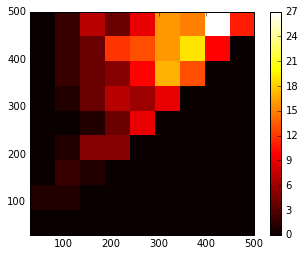

In [217]:
H, xedges, yedges = np.histogram2d(pt0s, pt1s, bins = (xedges, yedges))
plt.imshow(H, interpolation = 'nearest', cmap = 'hot', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
plt.show()

In [92]:
xedges = np.linspace(variable_ranges["JetEta"][0], variable_ranges["JetEta"][1], 3)
yedges = np.linspace(variable_ranges["JetEta"][0], variable_ranges["JetEta"][1], 3)

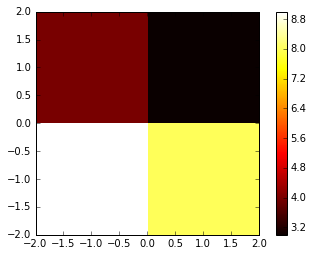

In [93]:
H, xedges, yedges = np.histogram2d(eta0s, eta1s, bins = (xedges, yedges))
plt.imshow(H, interpolation = 'nearest', cmap = 'hot', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
plt.show()

In [98]:
bins = np.linspace(variable_ranges["ZZEta"][0], variable_ranges["ZZEta"][1], 35)

In [99]:
plt.hist(ZZetas, bins)

(array([ 2.,  1.,  2.,  6.,  6.,  1.,  5.,  3.,  2.,  3.,  1.,  4.,  1.,
         2.,  5.,  1.,  3.,  3.,  5.,  1.,  5.,  2.,  2.,  4.,  3.,  1.,
         1.,  2.,  3.,  3.,  2.,  1.,  2.,  4.]),
 array([-1.        , -0.94117647, -0.88235294, -0.82352941, -0.76470588,
        -0.70588235, -0.64705882, -0.58823529, -0.52941176, -0.47058824,
        -0.41176471, -0.35294118, -0.29411765, -0.23529412, -0.17647059,
        -0.11764706, -0.05882353,  0.        ,  0.05882353,  0.11764706,
         0.17647059,  0.23529412,  0.29411765,  0.35294118,  0.41176471,
         0.47058824,  0.52941176,  0.58823529,  0.64705882,  0.70588235,
         0.76470588,  0.82352941,  0.88235294,  0.94117647,  1.        ]),
 <a list of 34 Patch objects>)

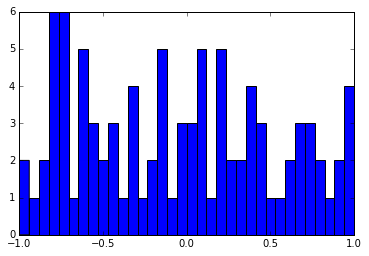

In [100]:
plt.show()